### Objectives
The purpose of this notebook is to develop a solid understanding of the variables in the dataset and their relationship to one another in order to guide ML model development. Insights will help steer which types of models would best address the overall project objetive as well as the additional preprocessing required to have a dataset which is ready for ML application.

As a secondary objective, the descriptive analysis can be used to test assumptions held within the business and draw out preliminary insights. 

### Insights of Interest
(Placeholder to insert the most important insights, create interactive plotly plots for these select few)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt

In [2]:
#enabling importing of modules from utils directory

# construct path to utils directory
path_to_utils = os.path.abspath(os.path.join(os.path.dirname('__file__'), 'utils')) 

# avoid adding multiple times
if path_to_utils not in sys.path:
    sys.path.append(path_to_utils)

In [28]:
df = pd.read_excel("./data/cleaned_data.xlsx")

In [29]:
df.head()

,id,name,goal,pledged,state,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,staff_pick,backers_count,static_usd_rate,usd_pledged,category,spotlight,name_len,name_len_clean,blurb_len,blurb_len_clean,deadline_weekday,state_changed_at_weekday,created_at_weekday,launched_at_weekday,deadline_month,deadline_day,deadline_yr,deadline_hr,state_changed_at_month,state_changed_at_day,state_changed_at_yr,state_changed_at_hr,created_at_month,created_at_day,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,usd_goal,name2,name_len2,name_len_clean_2
0,1538064060,MAGIC PIXEL - Bluetooth full color LED display,15000.0,5933.0,failed,False,GB,GBP,2016-03-19 09:31:29,2016-03-19 09:31:32,2015-12-18 03:17:13,2016-02-18 09:31:29,False,66,1.429989,8484.125686,Gadgets,False,8.0,8.0,18.0,14.0,Saturday,Saturday,Friday,Thursday,3,19,2016,9,3,19,2016,9,12,18,2015,3,2,18,2016,9,62,30,30,21450,MAGIC PIXEL - Bluetooth full color LED display,8,8
1,556771080,SmartPi - Turn your Raspberry Pi into a SmartM...,9000.0,16552.0,successful,False,DE,EUR,2016-04-03 08:05:09,2016-04-03 08:05:10,2016-02-08 09:27:33,2016-02-18 08:05:09,False,131,1.114939,18454.471487,Uncategorized,True,9.0,6.0,23.0,15.0,Sunday,Sunday,Monday,Thursday,4,3,2016,8,4,3,2016,8,2,8,2016,9,2,18,2016,8,9,45,45,10034,SmartPi - Turn your Raspberry Pi into a SmartM...,9,6
2,839314928,PlantSitter - The World's Smartest Plant Monit...,60000.0,43234.0,canceled,False,US,USD,2016-03-29 08:01:08,2016-03-28 09:46:41,2016-01-31 05:21:52,2016-02-18 08:01:08,False,632,1.000000,43234.000000,Gadgets,False,8.0,8.0,22.0,12.0,Tuesday,Monday,Sunday,Thursday,3,29,2016,8,3,28,2016,9,1,31,2016,5,2,18,2016,8,18,40,39,60000,PlantSitter - The World's Smartest Plant Monit...,8,7
3,681077916,Digital Video LUT Box for Colorblindness Corre...,125000.0,1262.0,canceled,False,US,USD,2016-03-19 07:48:02,2016-02-23 09:30:28,2016-01-28 11:21:14,2016-02-18 07:48:02,False,4,1.000000,1262.000000,Hardware,False,7.0,6.0,24.0,16.0,Saturday,Tuesday,Thursday,Thursday,3,19,2016,7,2,23,2016,9,1,28,2016,11,2,18,2016,7,20,30,5,125000,Digital Video LUT Box for Colorblindness Corre...,7,6
4,1315415013,help send Object Collection to Norway!,2000.0,2300.0,successful,False,US,USD,2016-03-03 17:00:00,2016-03-03 17:00:00,2016-02-16 10:00:06,2016-02-18 07:00:44,False,29,1.000000,2300.000000,Experimental,True,6.0,5.0,19.0,13.0,Thursday,Thursday,Tuesday,Thursday,3,3,2016,17,3,3,2016,17,2,16,2016,10,2,18,2016,7,1,14,14,2000,help send Object Collection to Norway!,6,5


In [11]:
print(df.duplicated().sum()) # no duplicates. add to data cleaning notebook after. 

0


### Preparation

In [4]:
df.columns

Index(['id', 'name', 'goal', 'pledged', 'state', 'disable_communication',
       'country', 'currency', 'deadline', 'state_changed_at', 'created_at',
       'launched_at', 'staff_pick', 'backers_count', 'static_usd_rate',
       'usd_pledged', 'category', 'spotlight', 'name_len', 'name_len_clean',
       'blurb_len', 'blurb_len_clean', 'deadline_weekday',
       'state_changed_at_weekday', 'created_at_weekday', 'launched_at_weekday',
       'deadline_month', 'deadline_day', 'deadline_yr', 'deadline_hr',
       'state_changed_at_month', 'state_changed_at_day', 'state_changed_at_yr',
       'state_changed_at_hr', 'created_at_month', 'created_at_day',
       'created_at_yr', 'created_at_hr', 'launched_at_month',
       'launched_at_day', 'launched_at_yr', 'launched_at_hr',
       'create_to_launch_days', 'launch_to_deadline_days',
       'launch_to_state_change_days', 'usd_goal', 'name2', 'name_len2',
       'name_len_clean_2'],
      dtype='object')

In [24]:
# checking if currency always matches with country
df['cc'] = df['country'] + df['currency']

In [7]:
df['cc'].unique() # currency for fundraising does not differ in the same country. no extra information captured having both the country and currency variable

array(['GBGBP', 'DEEUR', 'USUSD', 'AUAUD', 'CACAD', 'NONOK', 'FREUR',
       'BEEUR', 'NZNZD', 'ITEUR', 'SESEK', 'IEEUR', 'DKDKK', 'ESEUR',
       'NLEUR', 'CHCHF', 'ATEUR', 'LUEUR'], dtype=object)

In [25]:
# dropping unnecessary columns
df = df.drop(columns=['id', 'goal', 'pledged', 'currency', 'cc', 'deadline', 
                      'static_usd_rate', 'name', 'name_len', 'name_len_clean' ], axis=1)
# dropping id col
# non-US currency cols
# retaining timestamps even though they've already been broken down into individual variables since it may be helpful for feature engineering later.
# the ones i remade. 

In [6]:
catcols = df.select_dtypes(include=['object', 'bool']).columns.to_list()

In [7]:
numcols = [col for col in df.columns if col not in catcols]

In [14]:
df.dtypes

state                           object
disable_communication             bool
country                         object
staff_pick                        bool
backers_count                    int64
usd_pledged                    float64
category                        object
spotlight                         bool
blurb_len                      float64
blurb_len_clean                float64
deadline_weekday                object
state_changed_at_weekday        object
created_at_weekday              object
launched_at_weekday             object
deadline_month                   int64
deadline_day                     int64
deadline_yr                      int64
deadline_hr                      int64
state_changed_at_month           int64
state_changed_at_day             int64
state_changed_at_yr              int64
state_changed_at_hr              int64
created_at_month                 int64
created_at_day                   int64
created_at_yr                    int64
created_at_hr            

In [ ]:
# will need to consider how to treat these date ones later. 
# ordinalcols = df.['deadline_weekday','deadline_month', ]
# datetimecols = df.['']

In [11]:
numcols

['backers_count',
 'usd_pledged',
 'blurb_len',
 'blurb_len_clean',
 'deadline_month',
 'deadline_day',
 'deadline_yr',
 'deadline_hr',
 'state_changed_at_month',
 'state_changed_at_day',
 'state_changed_at_yr',
 'state_changed_at_hr',
 'created_at_month',
 'created_at_day',
 'created_at_yr',
 'created_at_hr',
 'launched_at_month',
 'launched_at_day',
 'launched_at_yr',
 'launched_at_hr',
 'create_to_launch_days',
 'launch_to_deadline_days',
 'launch_to_state_change_days',
 'usd_goal',
 'name_len2',
 'name_len_clean_2']

### Univariate Analysis

In [45]:
# descriptive statistics on numerical variables. # when cleaning up, remove date variables from the calculation
pd.set_option('display.max_columns', None)
df.describe().round(2)

,backers_count,usd_pledged,blurb_len,blurb_len_clean,deadline_month,deadline_day,deadline_yr,deadline_hr,state_changed_at_month,state_changed_at_day,state_changed_at_yr,state_changed_at_hr,created_at_month,created_at_day,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,usd_goal,name_len2,name_len_clean_2
count,15474.00,15474.00,15470.00,15470.00,15474.00,15474.00,15474.00,15474.00,15474.00,15474.00,15474.00,15474.00,15474.00,15474.00,15474.00,15474.00,15474.00,15474.00,15474.00,15474.00,15474.00,15474.00,15474.00,1.547400e+04,15474.00,15474.00
mean,181.17,19975.49,18.99,13.03,6.78,15.66,2014.37,13.05,6.78,15.65,2014.37,12.99,6.54,15.53,2014.17,12.84,6.62,15.30,2014.29,12.59,46.91,34.68,32.02,9.474142e+04,5.80,4.73
std,1287.83,114439.55,4.64,3.26,3.42,9.04,1.12,6.06,3.41,8.99,1.12,6.06,3.31,8.75,1.13,5.92,3.36,8.78,1.12,5.59,101.77,11.98,13.67,1.462852e+06,2.84,2.25
min,0.00,0.00,1.00,1.00,1.00,1.00,2009.00,0.00,1.00,1.00,2009.00,0.00,1.00,1.00,2009.00,0.00,1.00,1.00,2009.00,0.00,0.00,1.00,0.00,1.000000e+00,1.00,0.00
25%,2.00,24.86,17.00,11.00,4.00,8.00,2014.00,9.00,4.00,8.00,2014.00,9.00,4.00,8.00,2014.00,9.00,4.00,8.00,2014.00,9.00,3.00,30.00,29.00,4.000000e+03,3.00,3.00
50%,12.00,676.84,20.00,13.00,7.00,15.00,2015.00,13.00,7.00,15.00,2015.00,13.00,7.00,15.00,2014.00,13.00,7.00,15.00,2015.00,13.00,13.00,30.00,30.00,1.250000e+04,6.00,5.00
75%,63.00,5896.88,22.00,15.00,10.00,23.00,2015.00,18.00,10.00,23.00,2015.00,17.00,9.00,23.00,2015.00,17.00,10.00,23.00,2015.00,17.00,43.00,40.00,35.00,4.482050e+04,8.00,6.00
max,105857.00,6225354.98,35.00,30.00,12.00,31.00,2016.00,23.00,12.00,31.00,2016.00,23.00,12.00,31.00,2016.00,23.00,12.00,31.00,2016.00,23.00,1528.00,91.00,91.00,1.000000e+08,16.00,14.00


*Observations (First Pass)*
* Zero minimums for backers count and usd pledged makes sense since some may have been cancelled/ just started / suspended. For analysis, could help to limit to only records which were not suspended + those who had been running for at least a quarter of their expected run time by the time of data extraction. Potentially only those that completed their run or were cancelled. 
* 25th percentile to 75th percentile fairly close together for backers_count and usd_pledged as well but the max is very far from that. Check distribution & check with SMEs for if these should be considered outliers or if there's an expected portion of projects that would have those very high numbers
* From funding goals, minimum may be a "problem" record since the goal is only $1. Perhaps a minimum goal should be enforced (if this isn't already a suspended project). Median project goal is $12,500. 75th percentile ~$45,000. But then max is $100 mill. Similar to other monetary variables, need to check the spread, historical patterns, and SME knowledge to understand how to treat these cases. 
* Check distribution for how many 2009 records we have. May not be representative of current (assuming we are in 2016) base. If just a few, could omit.
* 25% to 75% fairly close together but some extremes in create to launch, launch to deadline, and launch to state change days. Check if any pattern to that
* The min and max values of datetime variables show the dataset has entries ranging from 2009 to 2016 and that there is meaningful project activitiy happening throughout the year (months, days, times of day)


**Data Distributions**

In [8]:
datetimecols = ['deadline_month','deadline_day','deadline_yr','deadline_hr','state_changed_at_month','state_changed_at_day',
                'state_changed_at_yr', 'state_changed_at_hr','created_at_month','created_at_day','created_at_yr','created_at_hr','launched_at_month',
                'launched_at_day', 'launched_at_yr','launched_at_hr']

In [9]:
numcols = [col for col in df.columns if col not in catcols + datetimecols]

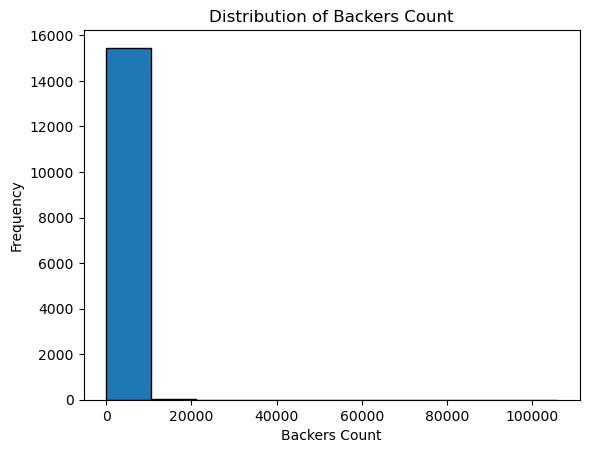

In [25]:
# just another check. since below plot gives almost no info beyond the spread
# i'll need to display the data for backers count in a different way. maybe the boxplot will help.
# same w usd_pledged and usd_goal
# Create histogram
plt.hist(df['backers_count'], bins=10, edgecolor='black')

# Set labels and title
plt.xlabel('Backers Count')
plt.ylabel('Frequency')
plt.title('Distribution of Backers Count')

# Show the histogram
plt.show()

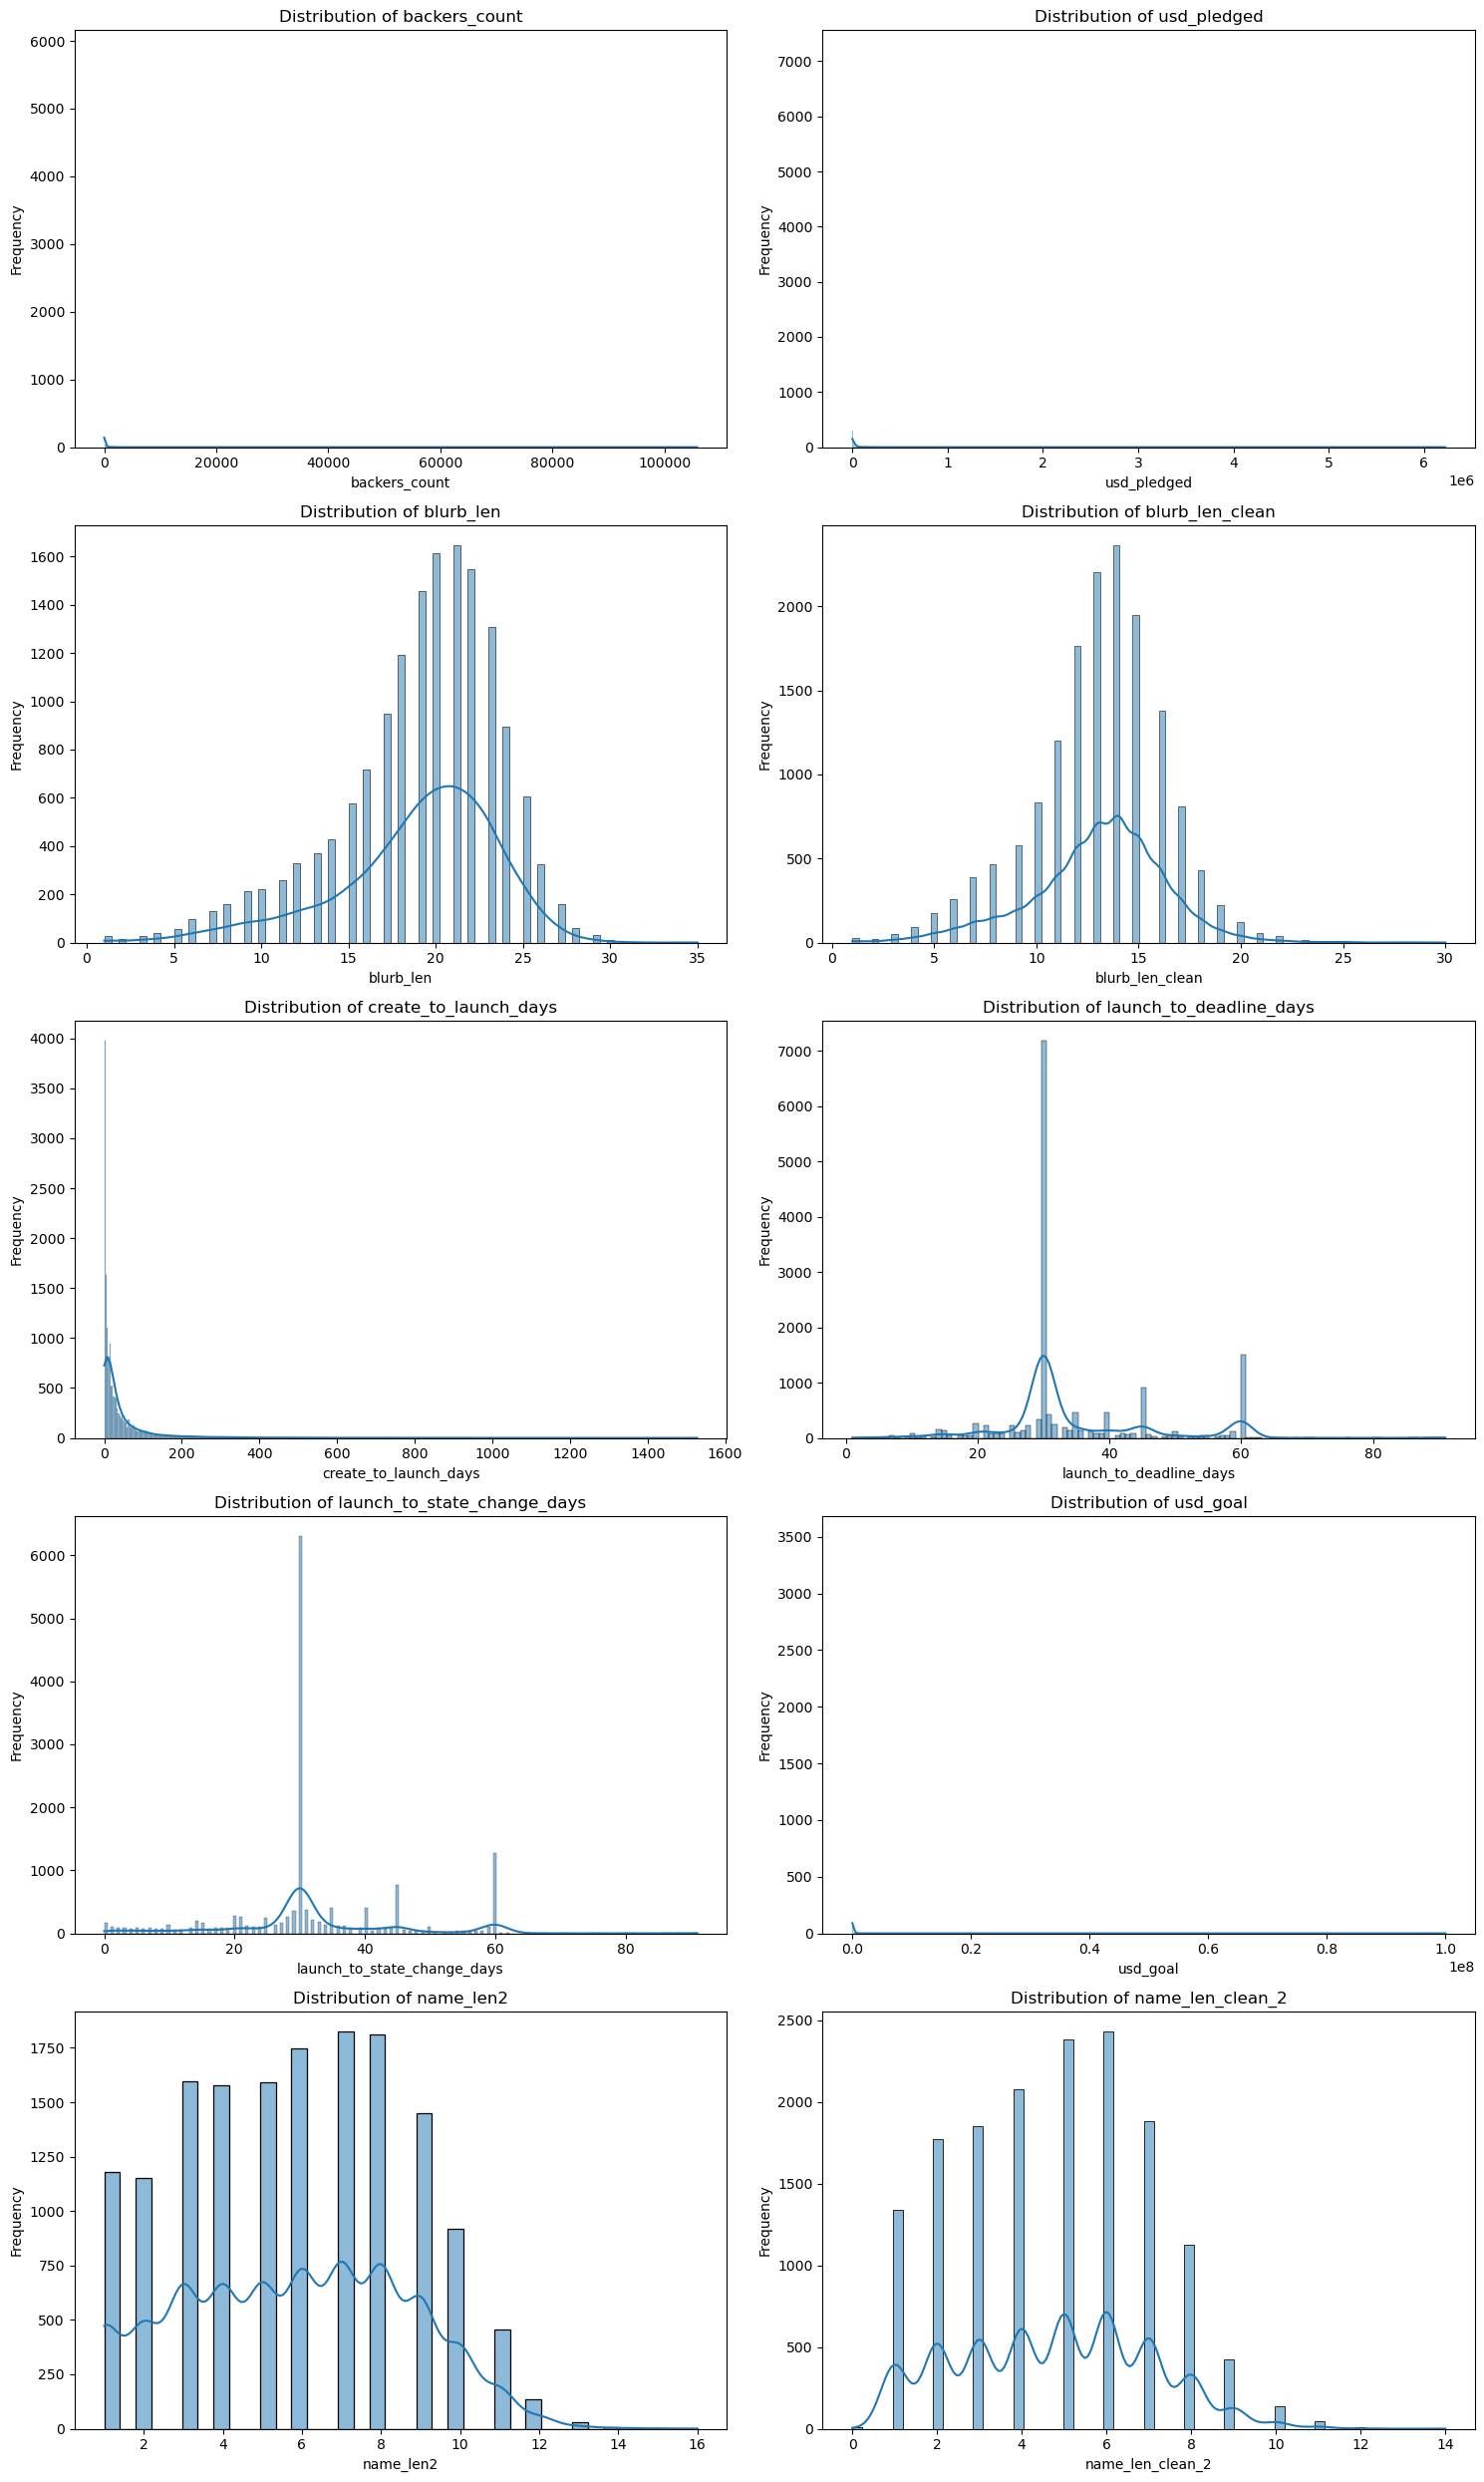

In [22]:
# Set figure layout
n_cols = 2 
n_rows = (len(numcols) + n_cols - 1) // n_cols 

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration if it's multidimensional
axes = axes.flatten() if n_rows > 1 else [axes]

# Plot histograms for each column
for i, col in enumerate(numcols):
    sns.histplot(df[col], kde=True, ax=axes[i]) #kde to visualize probabibility density of data
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [17]:
# trying to make a call on distribution for blurb_len_clean
mean_blurb_len_clean = df['blurb_len_clean'].mean()
median_blurb_len_clean = df['blurb_len_clean'].median()
mode_blurb_len_clean = df['blurb_len_clean'].mode()[0]

mean_blurb_len_clean, median_blurb_len_clean, mode_blurb_len_clean

(13.031286360698125, 13.0, 14.0)

*Observations - First Pass*
* Extremely high right skew in `backers_count`, `usd_pledged`, and `usd_goal` with a slight lift near 0. This warrants another look at the data to identify outliers and the distribution of the data without them. 
* Distribution of blurb_len is skewed left slightly but with stop words removed in blurb_len_clean it becomes a farily normal distribution (mean ~13, median ~13, mode ~14). 
* Create to launch days has a significant right skew, with most clustering between 0 and 100 days and some staying in that state for years. Another place to check for outliers
* Launch to deadline days has a bimodal distribution with the most significant peak around 30 days. And another much smaller one around 60 days. Believe the major peak is consistent with advice on the site to have funding periods of 30 days or less. 
* Launch to status change days is better interpreted when stratified by status.
* name_len and name_len_clean unimaodal and roughly symmetrical around their peaks. 

*On second pass, be more strict about the "so what"*

In [14]:
df['state'].unique()

array(['failed', 'successful', 'canceled', 'suspended'], dtype=object)

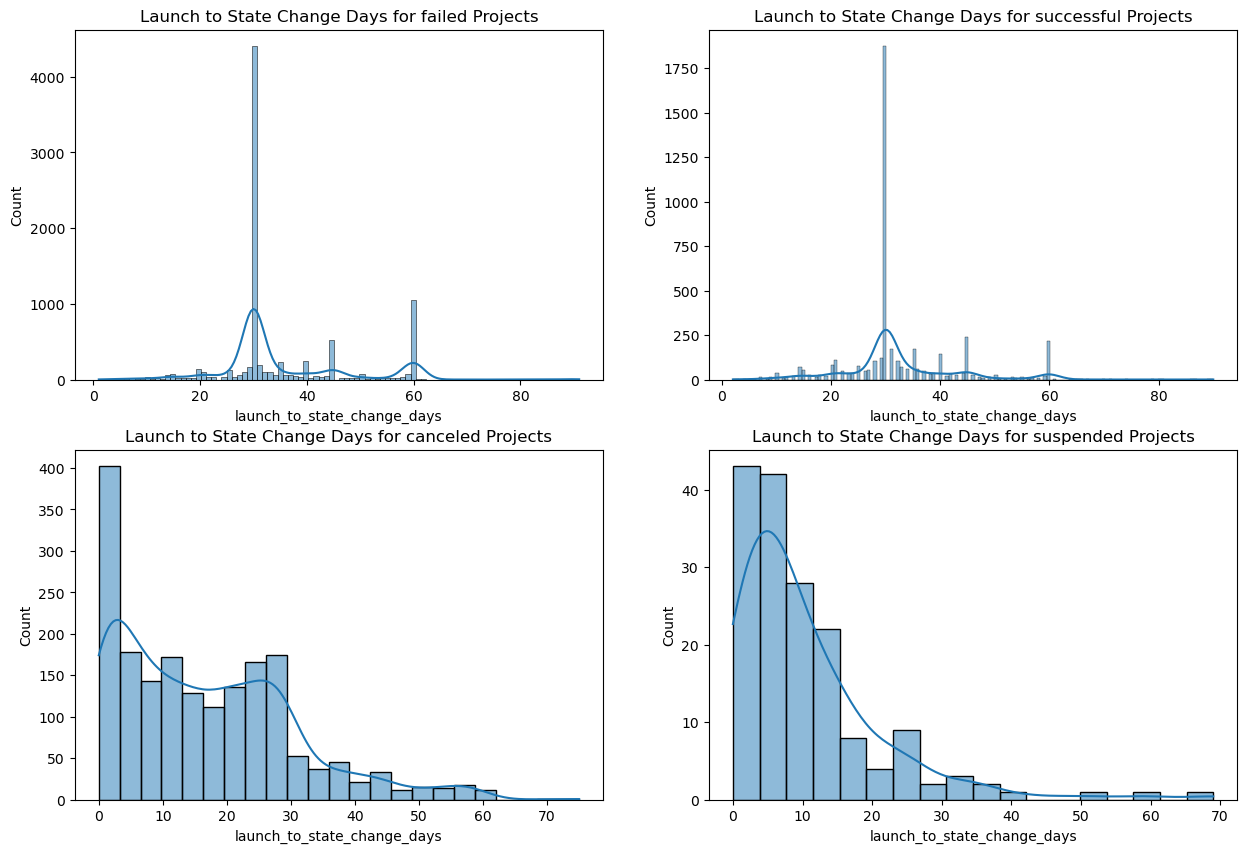

In [16]:
# launch to status change histograms broken out by status 
unique_states = df['state'].unique()
n_cols = 2
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration if it's multidimensional
axes = axes.flatten() if n_rows > 1 else [axes]

# Iterate through each unique state and plot the histogram
for i, state in enumerate(unique_states):
    state_data = df[df['state'] == state]['launch_to_state_change_days']
    
    # Plot the histogram
    sns.histplot(state_data, kde=True, ax=axes[i])
    
    # Set the title for each subplot
    axes[i].set_title(f'Launch to State Change Days for {state} Projects')

* Similar distributions for the number of days it takes for a project to enter status failed or successful. Both multimodal with peaks around the same number of days: 30, 45, and 60. Also similar ranges. This may indicate the typical campaign durations. This can be verified by checking number of days between when projects tend to be launched and their deadline. Plots below validate this hypothesis. Same distribution. The similarity in distribution in days to state change here is from projects coming to a natural close as planned at launch. 
* Days to cancel project is right-skewed with the mode near 0. This may be due to the fact that certain elements of a project cannot be edited after launch for maintaining accountability. This, if there's a real error, the user must cancel to make such changes. There's also another peak around 30 days. This may be users cancelling projects if it appears the project will fail **test this later**
* For suspended projects, there is a more signifanct right skew and some gaps in the distribution between ~40 and 70 days. The clusteering between 0 and 10 days shows mechanisms for spotting proejects which do not align with the nature of Kickstarter are working quite well.

In [19]:
pd.set_option('display.max_columns', None)
df.head()

,state,disable_communication,country,staff_pick,backers_count,usd_pledged,category,spotlight,blurb_len,blurb_len_clean,deadline_weekday,state_changed_at_weekday,created_at_weekday,launched_at_weekday,deadline_month,deadline_day,deadline_yr,deadline_hr,state_changed_at_month,state_changed_at_day,state_changed_at_yr,state_changed_at_hr,created_at_month,created_at_day,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,usd_goal,name2,name_len2,name_len_clean_2
0,failed,False,GB,False,66,8484.125686,Gadgets,False,18.0,14.0,Saturday,Saturday,Friday,Thursday,3,19,2016,9,3,19,2016,9,12,18,2015,3,2,18,2016,9,62,30,30,21450,MAGIC PIXEL - Bluetooth full color LED display,8,8
1,successful,False,DE,False,131,18454.471487,Uncategorized,True,23.0,15.0,Sunday,Sunday,Monday,Thursday,4,3,2016,8,4,3,2016,8,2,8,2016,9,2,18,2016,8,9,45,45,10034,SmartPi - Turn your Raspberry Pi into a SmartM...,9,6
2,canceled,False,US,False,632,43234.000000,Gadgets,False,22.0,12.0,Tuesday,Monday,Sunday,Thursday,3,29,2016,8,3,28,2016,9,1,31,2016,5,2,18,2016,8,18,40,39,60000,PlantSitter - The World's Smartest Plant Monit...,8,7
3,canceled,False,US,False,4,1262.000000,Hardware,False,24.0,16.0,Saturday,Tuesday,Thursday,Thursday,3,19,2016,7,2,23,2016,9,1,28,2016,11,2,18,2016,7,20,30,5,125000,Digital Video LUT Box for Colorblindness Corre...,7,6
4,successful,False,US,False,29,2300.000000,Experimental,True,19.0,13.0,Thursday,Thursday,Tuesday,Thursday,3,3,2016,17,3,3,2016,17,2,16,2016,10,2,18,2016,7,1,14,14,2000,help send Object Collection to Norway!,6,5


In [32]:
# Ensuredatetime column
df['launched_at'] = pd.to_datetime(df['launched_at'])
df['deadline'] = pd.to_datetime(df['deadline'])

# Extract only the date part
df['launched_at_date'] = df['launched_at'].dt.date
df['deadline'] = df['deadline'].dt.date

# Calculate the planned duration in days
df['planned_duration'] = (df['deadline_date'] - pd.to_datetime(df['launched_at_date'])).dt.days

In [33]:
df.head()

,id,name,goal,pledged,state,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,staff_pick,backers_count,static_usd_rate,usd_pledged,category,spotlight,name_len,name_len_clean,blurb_len,blurb_len_clean,deadline_weekday,state_changed_at_weekday,created_at_weekday,launched_at_weekday,deadline_month,deadline_day,deadline_yr,deadline_hr,state_changed_at_month,state_changed_at_day,state_changed_at_yr,state_changed_at_hr,created_at_month,created_at_day,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,usd_goal,name2,name_len2,name_len_clean_2,deadline_date,launched_at_date,planned_duration
0,1538064060,MAGIC PIXEL - Bluetooth full color LED display,15000.0,5933.0,failed,False,GB,GBP,2016-03-19,2016-03-19 09:31:32,2015-12-18 03:17:13,2016-02-18 09:31:29,False,66,1.429989,8484.125686,Gadgets,False,8.0,8.0,18.0,14.0,Saturday,Saturday,Friday,Thursday,3,19,2016,9,3,19,2016,9,12,18,2015,3,2,18,2016,9,62,30,30,21450,MAGIC PIXEL - Bluetooth full color LED display,8,8,2016-03-19,2016-02-18,30
1,556771080,SmartPi - Turn your Raspberry Pi into a SmartM...,9000.0,16552.0,successful,False,DE,EUR,2016-04-03,2016-04-03 08:05:10,2016-02-08 09:27:33,2016-02-18 08:05:09,False,131,1.114939,18454.471487,Uncategorized,True,9.0,6.0,23.0,15.0,Sunday,Sunday,Monday,Thursday,4,3,2016,8,4,3,2016,8,2,8,2016,9,2,18,2016,8,9,45,45,10034,SmartPi - Turn your Raspberry Pi into a SmartM...,9,6,2016-04-03,2016-02-18,45
2,839314928,PlantSitter - The World's Smartest Plant Monit...,60000.0,43234.0,canceled,False,US,USD,2016-03-29,2016-03-28 09:46:41,2016-01-31 05:21:52,2016-02-18 08:01:08,False,632,1.000000,43234.000000,Gadgets,False,8.0,8.0,22.0,12.0,Tuesday,Monday,Sunday,Thursday,3,29,2016,8,3,28,2016,9,1,31,2016,5,2,18,2016,8,18,40,39,60000,PlantSitter - The World's Smartest Plant Monit...,8,7,2016-03-29,2016-02-18,40
3,681077916,Digital Video LUT Box for Colorblindness Corre...,125000.0,1262.0,canceled,False,US,USD,2016-03-19,2016-02-23 09:30:28,2016-01-28 11:21:14,2016-02-18 07:48:02,False,4,1.000000,1262.000000,Hardware,False,7.0,6.0,24.0,16.0,Saturday,Tuesday,Thursday,Thursday,3,19,2016,7,2,23,2016,9,1,28,2016,11,2,18,2016,7,20,30,5,125000,Digital Video LUT Box for Colorblindness Corre...,7,6,2016-03-19,2016-02-18,30
4,1315415013,help send Object Collection to Norway!,2000.0,2300.0,successful,False,US,USD,2016-03-03,2016-03-03 17:00:00,2016-02-16 10:00:06,2016-02-18 07:00:44,False,29,1.000000,2300.000000,Experimental,True,6.0,5.0,19.0,13.0,Thursday,Thursday,Tuesday,Thursday,3,3,2016,17,3,3,2016,17,2,16,2016,10,2,18,2016,7,1,14,14,2000,help send Object Collection to Norway!,6,5,2016-03-03,2016-02-18,14


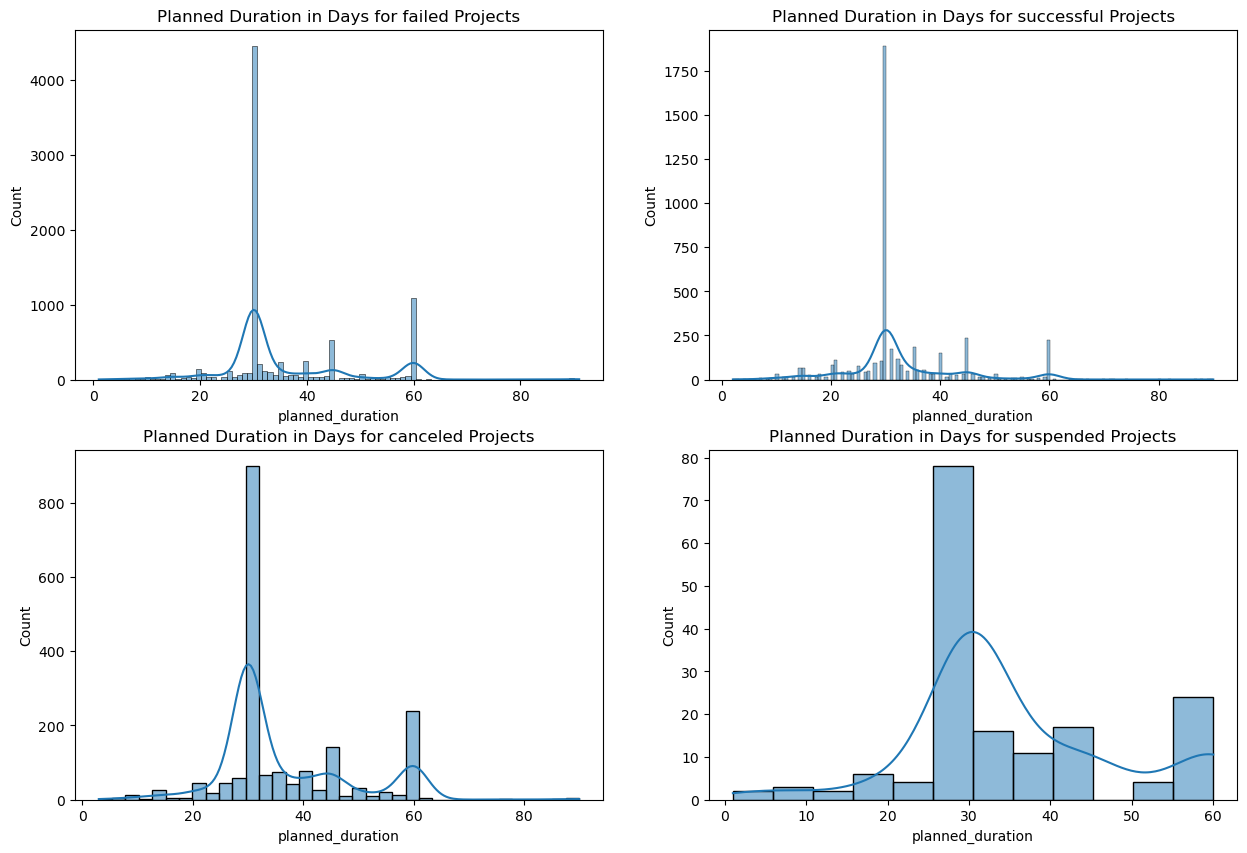

In [34]:

unique_states = df['state'].unique()
n_cols = 2
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration if it's multidimensional
axes = axes.flatten() if n_rows > 1 else [axes]

# Iterate through each unique state and plot the histogram
for i, state in enumerate(unique_states):
    state_data = df[df['state'] == state]['planned_duration']
    
    # Plot the histogram
    sns.histplot(state_data, kde=True, ax=axes[i])
    
    # Set the title for each subplot
    axes[i].set_title(f'Planned Duration in Days for {state} Projects')

* Projects which were cancelled have a similar planned duration to those who went their full length, indicating similar practices being followed across the platform for duration. (confirm if kickstarter has suggested durations. This could validate that this is being largely followed)

In [ ]:
# histogram and boxplot distributions of numerical variables

In [ ]:
# check number of unique values for categorical variables

In [ ]:
# frequency distributions of categrocial variables

In [ ]:
# check proportion assigned to each of the top 10 values for the categorical variables

In [ ]:
# check nature of categories for sense of how to encode 

### Bivariate Analysis

In [ ]:
# create version of dataset with encoded categoricals and normalized numerical, perform 2 component PCA and plot for an initial idea of whether there are clusters present
# make commentary, but don't abandon clustering yet

In [ ]:
# pairplots for all the numerical variables, see if any relationships to observe. 
# especially among variables which seemed to have meaningful divides in the univariate analysis

### Multivariate

In [ ]:
# correlation martrix for numerical
# chi-square tests for categorical

In [ ]:
# check proportion of each categorical variable value that is in each state (mosaic plot)

In [ ]:
# interesting bivariate plots from earlier color coded by state

### Multivariate Analysis